In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import pandas as pd
import geopandas as gpd
from pathlib import Path
import deepdiff

from cider.homelocation.inference import get_home_locations, get_accuracy
from cider.schemas import GeographicUnit, GetHomeLocationAlgorithm, CallDataRecordData, AntennaData
from cider.homelocation.plotting import make_location_map

# WILL BE DEPRECATED IN FUTURE VERSIONS
import sys
sys.path.insert(0,'..')
from deprecated.home_location import DataStore, HomeLocator

In [3]:
# Load data
DATA_DIR = Path('../synthetic_data/')
cdr = pd.read_csv(DATA_DIR / 'cdr.csv')
outgoing = cdr[['caller_id', 'caller_antenna', 'timestamp']]\
    .rename({'caller_antenna':'caller_antenna_id'}, axis=1)
incoming = cdr[['recipient_id', 'recipient_antenna', 'timestamp']]\
    .rename({'recipient_antenna':'recipient_antenna_id'}, axis=1)
cdr = pd.concat([outgoing, incoming])
antennas = pd.read_csv(DATA_DIR / 'antennas.csv').dropna()
home_locations_gt = pd.read_csv(DATA_DIR / 'home_locations.csv').rename(
    columns={
        "subscriber_id": "caller_id",
        "antenna_id": "caller_antenna_id",
        "regions": "region"})
shapefile = gpd.read_file('../synthetic_data/regions.geojson')

In [4]:
# WILL BE DEPRECATED IN FUTURE VERSIONS
# We need this right now to load the spark session, and also to compare old vs new results
config_file = '../configs/config_new.yml'
datastore = DataStore(config_file)

setattr(datastore, "outputs", str(datastore.cfg.path.working.directory_path))

spark = datastore.spark

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/18 14:25:58 WARN Utils: Your hostname, Poornimas-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.26 instead (on interface en0)
25/11/18 14:25:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/18 14:25:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
cdr = cdr[~cdr.caller_antenna_id.isna()]

In [6]:
cdr

,caller_id,caller_antenna_id,timestamp,recipient_id,recipient_antenna_id
0,1.804791e+08,a101,2020-01-01 00:00:42,NaN,NaN
1,1.816165e+08,a44,2020-01-01 00:02:04,NaN,NaN
2,1.896533e+08,a145,2020-01-01 00:02:12,NaN,NaN
3,1.833317e+08,a84,2020-01-01 00:02:23,NaN,NaN
4,8.800190e+12,a261,2020-01-01 00:03:05,NaN,NaN
...,...,...,...,...,...
99995,8.800186e+12,a100,2020-02-29 23:56:26,NaN,NaN
99996,8.800188e+12,a6,2020-02-29 23:56:35,NaN,NaN
99997,1.845833e+08,a281,2020-02-29 23:57:46,NaN,NaN
99998,1.802744e+08,a184,2020-02-29 23:58:06,NaN,NaN


In [7]:
# Validate data using schemas
# CAN ignore invalid data errors for now -- rerun after fixing data generation scripts
_ = [CallDataRecordData.model_validate(row) for row in cdr.to_dict(orient="records")]
_ = [AntennaData.model_validate(row) for row in antennas.to_dict(orient="records")]

ValidationError: 6 validation errors for CallDataRecordData
caller_id
  Input should be a valid string [type=string_type, input_value=180479117.0, input_type=float]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
recipient_id
  Input should be a valid string [type=string_type, input_value=nan, input_type=float]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type
duration
  Field required [type=missing, input_value={'caller_id': 180479117.0...ipient_antenna_id': nan}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/missing
transaction_type
  Field required [type=missing, input_value={'caller_id': 180479117.0...ipient_antenna_id': nan}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/missing
transaction_scope
  Field required [type=missing, input_value={'caller_id': 180479117.0...ipient_antenna_id': nan}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/missing
recipient_antenna_id
  Input should be a valid string [type=string_type, input_value=nan, input_type=float]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type

In [11]:
# Run home location inference
geographic_unit = GeographicUnit.SHAPEFILE
algorithm = GetHomeLocationAlgorithm.COUNT_TRANSACTIONS

homes = get_home_locations(
    spark_session=spark,
    validated_cdr_data=cdr, # todo: ideally we should validate the synthetic data using the schemas
    validated_antenna_data=antennas, # todo: ideally we should validate the synthetic data using the schemas
    shapefile_data=shapefile,
    geographic_unit=geographic_unit,
    algorithm=algorithm,
    additional_columns_to_keep=[]
)
homes.head(10)

,caller_id,caller_antenna_id,count_transactions
0,180002964.0,a2,2
1,180013658.0,a230,3
2,180025080.0,a278,3
3,180029327.0,a245,3
4,180050817.0,a0,3
5,180068395.0,a174,3
6,180077109.0,a189,3
7,180085732.0,a100,3
8,180088875.0,a2,3
9,180106237.0,a274,2


In [9]:
(homes['caller_antenna_id'] == home_locations_gt['caller_antenna_id'])

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: caller_antenna_id, Length: 1000, dtype: bool

In [10]:
# Calculate accuracy
metrics_table = get_accuracy(homes, home_locations_gt, column_to_merge_on="caller_id", column_to_measure_on="caller_antenna_id")
metrics_table

,caller_antenna_id_groundtruth,recall,caller_antenna_id_inferred,precision
0,a0,0.0,a0,0.0
1,a1,0.0,a1,0.0
2,a10,0.0,a10,0.0
3,a100,0.0,a100,0.0
4,a101,0.0,a101,0.0
...,...,...,...,...
289,a95,0.0,a95,0.0
290,a96,0.0,a96,0.0
291,a97,0.0,a97,0.0
292,a98,0.0,a98,0.0


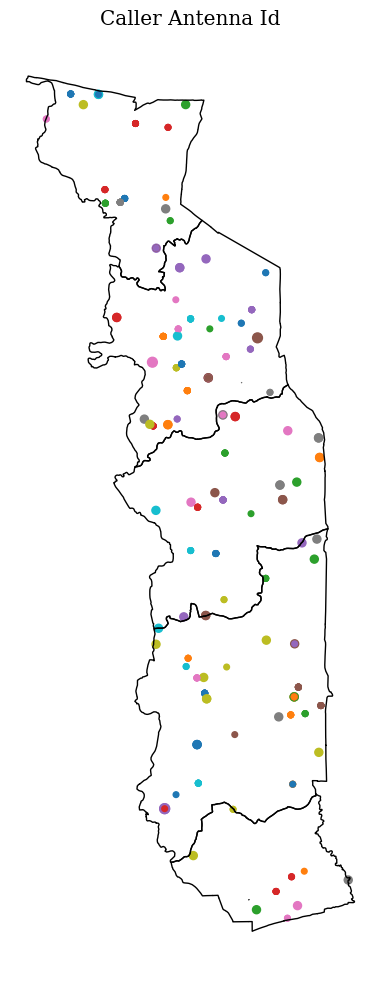

In [12]:
# Plotting results

merged = homes.merge(antennas, left_on='caller_antenna_id', right_on='antenna_id', how='left')
homes_gdf = gpd.GeoDataFrame(
    merged,
    geometry=gpd.points_from_xy(merged.longitude, merged.latitude),
    crs="EPSG:4326"
)
fig = make_location_map(
    inferred_home_locations=homes_gdf,
    boundaries_shapefile=shapefile,
    column_to_plot_label='caller_antenna_id',
    column_to_plot_markersize=algorithm.value,
)

In [ ]:
fig

In [ ]:
# Compare with previous way of doing things:
# WILL BE DEPRECATED IN FUTURE VERSIONS

# Reload data to ensure no contamination
old_cdr = pd.read_csv('../synthetic_data/cdr.csv')
old_outgoing = old_cdr[['caller_id', 'caller_antenna', 'timestamp']]\
    .rename({'caller_id':'name', 'caller_antenna':'antenna_id'}, axis=1)
old_incoming = old_cdr[['recipient_id', 'recipient_antenna', 'timestamp']]\
    .rename({'recipient_id':'name', 'recipient_antenna':'antenna_id'}, axis=1)
old_cdr = pd.concat([old_outgoing, old_incoming])
old_antennas = pd.read_csv('../synthetic_data/antennas.csv')
old_cdr = old_cdr.merge(old_antennas, on='antenna_id', how='inner')
old_home_locations = pd.read_csv('../synthetic_data/home_locations.csv')
old_shapefile = gpd.read_file('../synthetic_data/regions.geojson')

In [20]:
# Infer home locations using old method
algo = algorithm.value
home_locator = HomeLocator(datastore)
old_homes = home_locator.get_home_locations(geo="antenna_id", algo=algo).rename({'subscriber_id':'name'}, axis=1)

Loading CDR...
Loading antennas...


In [21]:
# Compare old and new
# Do some renaming to align columns
old_homes.rename(
    columns={
        "name": "caller_id",
        "antenna_id": "caller_antenna_id"}, 
        inplace=True)
ddiff = deepdiff.DeepDiff(
    old_homes.sort_values(by=['caller_id']).reset_index(drop=True),
    homes.sort_values(by=['caller_id']).reset_index(drop=True),
    ignore_order=True
)
ddiff # <-- should be empty dictionary if two things are the same

{}